In [309]:
%reset -f 
import numpy as np
import itertools
import matplotlib.pyplot as plt


def H(states, couplings, field=None):
    if field is None:
        field = np.zeros(states.shape[1])
    E_states = 0.5 * np.sum(states * (couplings @ states.T).T, axis=1) + states @ field
    return E_states

def make_symmetric(matrix):
    return np.triu(matrix, 1) + np.triu(matrix, 1).T

def get_couplings(J0, J, n):
    mean = J0 / n
    std = J / np.sqrt(n)
    # randn samples from normal distribution
    return make_symmetric(mean + std * np.random.randn(n, n))

def RMSE(vec1, vec2):
    vec1 = np.array(vec1) if isinstance(vec1, list) else vec1
    vec2 = np.array(vec2) if isinstance(vec2, list) else vec2
    assert np.array_equal(vec1.shape, vec2.shape), "Input vectors must have same shape"

    return np.sqrt(np.mean((vec1 - vec2) ** 2))

def exact(couplings:np.ndarray, field:np.ndarray, beta:int):
    # Get all random states
    n_spins = couplings.shape[0]
    spin_states = np.array(list(itertools.product([-1 ,1], repeat=n_spins)))
    spin_energies = H(spin_states, couplings, field)
    # Get energies and derive probablity
    spin_energies = np.exp(-beta * spin_energies)
    Z = np.sum(spin_energies)
    spin_probs = spin_energies / Z
    assert np.isclose(np.sum(spin_probs), 1), "Spin state probablities should sum up to 1"
    # Returns spin expectations
    spin_expts = spin_states.T @ spin_probs
    return spin_expts

def mf_approx(couplings:np.ndarray, field:np.ndarray, mf_convergence_threshold=1e-13):
    n_spins = couplings.shape[0]
    spin_means = np.random.uniform(-1, 1, n_spins)
    indexes = np.array(range(spin_means.size))
    max_diff_spin = 1e10
    diffs_spin = []
    while max_diff_spin > mf_convergence_threshold:
        old_spin_means = np.copy(spin_means)
        for i in indexes:
            null_inxs = np.concatenate([indexes[:i], indexes[i+1:] ])
            # add beta
            interaction = -beta * np.dot(spin_means[null_inxs], couplings[i, null_inxs])
            spin_means[i] = np.tanh(interaction + field[i])
        max_diff_spin = np.max(np.abs(old_spin_means - spin_means))
        diffs_spin.append(max_diff_spin)
    return spin_means, np.array(diffs_spin)

def correlation(spins, couplings):
    kronicker = -np.eye(spins.size) + 1
    denominator = 1 - np.power(np.array([spins] * spins.size), 2).T
    A_inverse = kronicker / denominator - couplings
    return  np.linalg.inv(A_inverse)

def main():
    global betas
    global RMSE_mean_mf
    global RMSE_corr_mf
    global iterations_mf

    # Params
    n_spins = 15
    n_betas = 10
    betas = np.linspace(0.1, 2, n_betas)
    J0 = 0
    J = 0.5
    J_field = 0.1
    n_trials = 10

    # Init couplings and random field
    couplings = get_couplings(J0, J, n_spins) # shape=(combination, spi
    fields = np.random.randn(n_trials, n_spins) * J_field 

    # Compute RMS error in mean
    RMSE_mean_mf = np.empty((n_betas, n_trials))
    RMSE_corr_mf = np.empty((n_betas, n_trials))
    iterations_mf = np.empty((n_betas, n_trials))
    # add correlation
    for row, beta in enumerate(betas):
        for col in range(n_trials):
            # Same field is used within trial
            # Different field is used between trials
            spin_expc_mf, diffs_spin_mf = mf_approx(couplings, fields[col, :])
            spin_expc_exact = exact(couplings, fields[col, :], beta) 

            RMSE_mean_mf[row, col] = RMSE(spin_expc_exact, spin_expc_mf)
            RMSE_corr_mf[row, col] = RMSE(correlation(spin_expc_mf, couplings), correlation(spin_expc_exact, couplings))

            iterations_mf[row, col] = np.size(diffs_spin_mf)


    
main()


In [308]:
def check_phase_transition():
    n_spins = 15
    n_betas = 10
    J0 = 0
    J = 0.5
    J_field = 0.1
    n_trials = 10

    couplings = get_couplings(J0, J, n_spins) # shape=(combination, spi
    Ts  = np.linspace(0.5, 5, 15)
    field = np.random.randn(n_spins) * J_field 
    for row, T in enumerate(Ts):
        # Get all random states
        spin_states = np.array(list(itertools.product([-1 ,1], repeat=n_spins)))
        spin_energies = H(spin_states, couplings, field)
        spin_energies = np.exp(-1/T * spin_energies)

        exact(n_spins, couplings, field, 1/T)


check_phase_transition

<function __main__.check_phase_transition()>

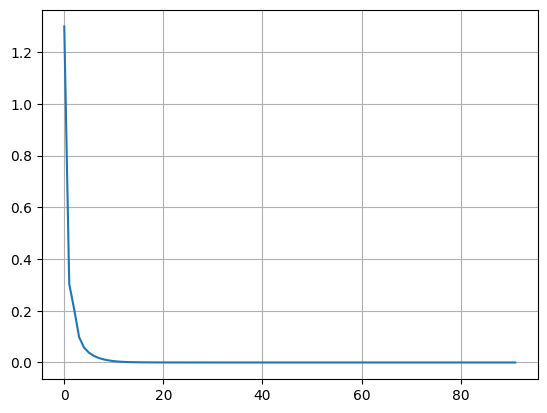

In [315]:
def check_mf_convergence():
    n_spins = 50
    J_field = 0.1
    J0 = 0
    J = 0.5
    
    field = np.random.randn(n_spins) * J_field 
    couplings = get_couplings(J0, J, n=n_spins)
    _, dms = mf_approx(couplings, field)

    plt.plot(dms)
    plt
    plt.grid()

    
check_mf_convergence()

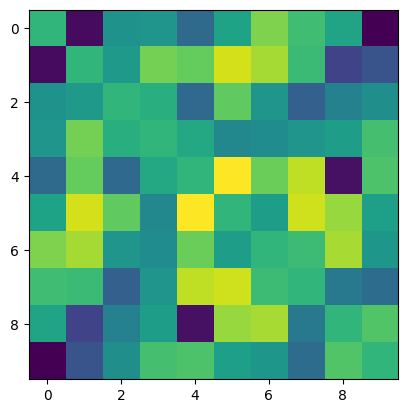

In [301]:
plt.imshow(get_couplings(J0=0, J=1, n=10))

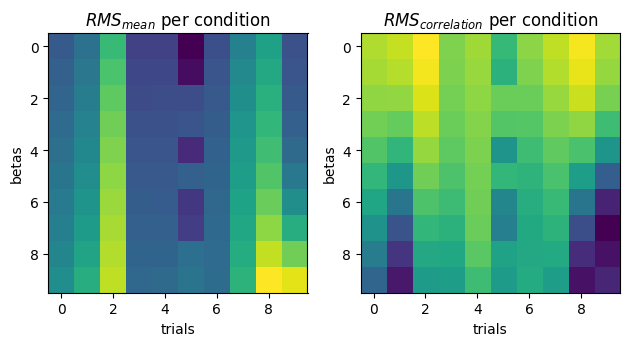

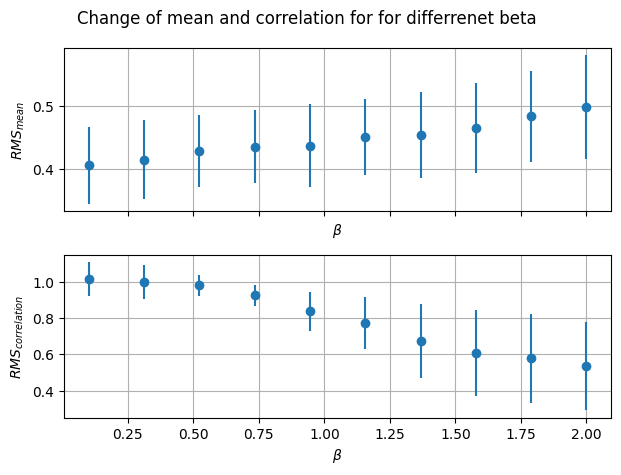

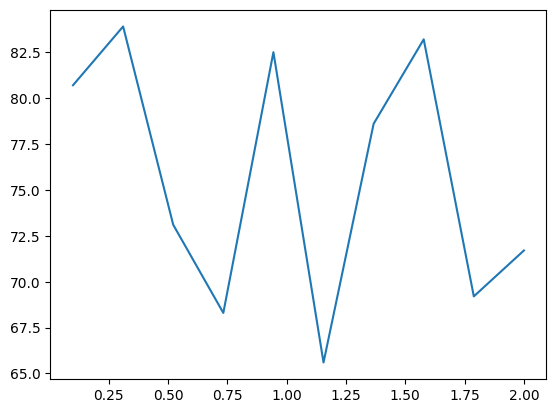

In [288]:
mean_RMSEmean_for_beta_mf = np.mean(RMSE_mean_mf, axis=1)
std_RMSEmean_for_beta_mf = np.std(RMSE_mean_mf, axis=1)
mean_RMSEcorr_for_beta_mf = np.mean(RMSE_corr_mf, axis=1)
std_RMSEcorr_for_beta_mf = np.std(RMSE_corr_mf, axis=1)
iterations_across_beta_mf = np.mean(iterations_mf, axis=1)

fig_im, axes_im = plt.subplots(1, 2)
axes_im[0].imshow(RMSE_mean_mf)
axes_im[0].set_xlabel('trials')
axes_im[0].set_ylabel('betas')
axes_im[0].set_title(r'$RMS_{mean}$ per condition')
axes_im[1].imshow(RMSE_corr_mf)
axes_im[1].set_xlabel('trials')
axes_im[1].set_ylabel('betas')
axes_im[1].set_title(r'$RMS_{correlation}$ per condition')
fig_im.tight_layout()

fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle("Change of mean and correlation for for differrenet beta")
ax[0].errorbar(betas, mean_RMSEmean_for_beta_mf, yerr=std_RMSEmean_for_beta_mf, fmt='o')
ax[0].grid(True)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel(r'$RMS_{mean}$')

ax[1].errorbar(betas, mean_RMSEcorr_for_beta_mf, yerr=std_RMSEcorr_for_beta_mf, fmt='o')
ax[1].grid(True)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$RMS_{correlation}$')
fig.tight_layout()

fig_iter, ax_iter = plt.subplots()
ax_iter.plot(betas, iterations_across_beta_mf)

